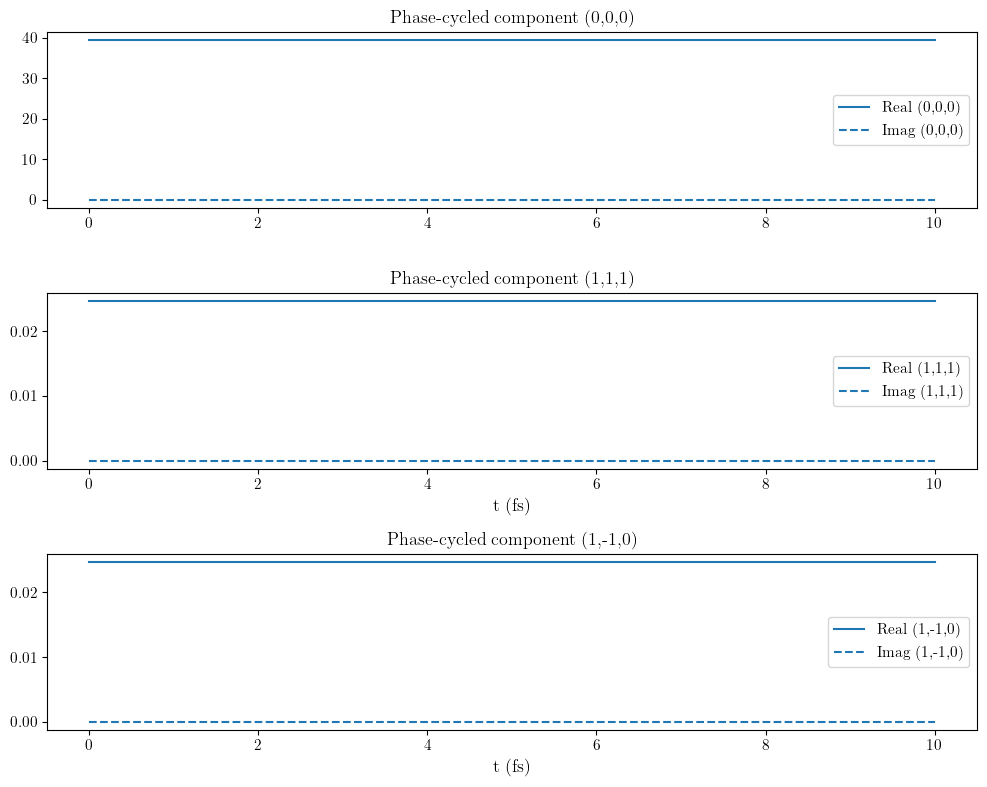

In [8]:
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
import numpy as np

def phase_cycle_component(
    phases: Sequence[float],
    P_grid: np.ndarray,
    *,
    lmn: Tuple[int, int, int] = (0, 0, 0),
    phi_det: float = 0.0,
) -> np.ndarray:
    """Extract P_{l,m,n}(t) from a grid P^3[phi1,phi2,t].

    P_{l,m,n}(t) = Σ_{phi1} Σ_{phi2} P^3_{phi1,phi2}(t) exp(-i(l phi1 + m phi2 + n phi_det))
    """
    l, m, n = lmn
    L, M, T = P_grid.shape
    phi = np.asarray(phases, float)
    P_out = np.zeros(T, dtype=complex)
    for i, phi1 in enumerate(phi):
        for k, phi2 in enumerate(phi):
            P_out += P_grid[i, k, :] * np.exp(-1j * (l * phi1 + m * phi2 + n * phi_det))

    return P_out / len(phases)**2 * (phases[-1] - phases[0])**2

# Test with constant P_grid
phases = np.linspace(0, 2*np.pi, 40)  # example phases
t = np.linspace(0, 10, 10)  # example time array
P_grid = np.full((len(phases), len(phases), len(t)), 1.0 + 0j, dtype=complex)  # constant values

# Compute for different lmn
P_out_000 = phase_cycle_component(phases, P_grid, lmn=(0, 0, 0))
P_out_111 = phase_cycle_component(phases, P_grid, lmn=(1, 1, 1))
P_out_1_m1_0 = phase_cycle_component(phases, P_grid, lmn=(1, -1, 0))
# Visualize
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
axes[0].plot(t, np.real(P_out_000), label='Real (0,0,0)')
axes[0].plot(t, np.imag(P_out_000), label='Imag (0,0,0)')
axes[0].set_title('Phase-cycled component (0,0,0)')
axes[0].legend()

axes[1].plot(t, np.real(P_out_111), label='Real (1,1,1)')
axes[1].plot(t, np.imag(P_out_111), label='Imag (1,1,1)')
axes[1].set_title('Phase-cycled component (1,1,1)')
axes[1].set_xlabel('t (fs)')
axes[1].legend()

axes[2].plot(t, np.real(P_out_1_m1_0), label='Real (1,-1,0)')
axes[2].plot(t, np.imag(P_out_1_m1_0), label='Imag (1,-1,0)')
axes[2].set_title('Phase-cycled component (1,-1,0)')
axes[2].set_xlabel('t (fs)')
axes[2].legend()

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import e_pulses
from qspectro2d.visualization import plot_example_evo, plot_el_field, plot_all_pulse_components, plot_pulse_envelopes, plot_e_pulses
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window, compute_evolution, sim_with_only_pulses, phase_cycle_component
from qspectro2d.utils.rwa_utils import get_expect_vals_with_RWA
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.spectroscopy.post_processing import compute_spectra
from plotstyle import init_style, COLORS, LINE_STYLES, save_fig
init_style()

from pathlib import Path
custom_dir = Path("test_Spectroscopy")
custom_dir.mkdir(exist_ok=True)

In [2]:
from qspectro2d.utils.constants import convert_cm_to_fs
# Parameters for the qubit system
omega0 = 16000      # transition frequency ~16000 cm⁻¹
omega0 = convert_cm_to_fs(omega0)  # convert to rad/fs
print(f"omega0 = {omega0:.2f} rad/fs")
Gamma = 0.05      # homogeneous dephasing rate = 1/10 fs⁻¹
Gamma1 = 1/100    # population decay rate = 1/100 fs⁻¹
t2 = 0.0          # waiting time (set to 0 for simplicity)

# Time grids for t_cohs and t_dets (coherence times)
dt = 0.1          # time step in fs
T_max = 300.0     # max time in fs
n_t = int(T_max / dt) + 1  # number of points
t_cohs = dt * np.arange(0, n_t)
t_dets = dt * np.arange(0, n_t)
T1, T3 = np.meshgrid(t_cohs, t_dets, indexing='ij')  # T1 is (n_t, n_t), etc.

# Individual response functions (time domain)
R1_time = np.exp(-1j * omega0 * T1 - Gamma * T1) * np.exp(-1j * omega0 * T3 - Gamma * T3) * np.exp(-Gamma1 * t2)
R2_time = np.exp(1j * omega0 * T1 - Gamma * T1) * np.exp(-1j * omega0 * T3 - Gamma * T3) * np.exp(-Gamma1 * t2)
R3_time = R2_time  # R3 = R2 for two-level system
R4_time = R1_time  # R4 = R1 for two-level system

# Combined for rephasing and non-rephasing
R_reph_time = R2_time + R3_time
R_nonr_time = R1_time + R4_time

omega0 = 3.01 rad/fs


In [3]:
# Compute spectra using the compute_spectra function with virtual padding
signal_types = ["rephasing", "nonrephasing"]
nu_cohs, nu_dets, datas_nu, out_types = compute_spectra([R_reph_time, R_nonr_time], signal_types, t_det=t_dets, t_coh=t_cohs, pad=4.0)

print(f"Frequency axes: nu_cohs shape {nu_cohs.shape}, nu_dets shape {nu_dets.shape}")
print(f"Output types: {out_types}")
print(f"Spectra shapes: {[d.shape for d in datas_nu]}")

Frequency axes: nu_cohs shape (12004,), nu_dets shape (12004,)
Output types: ['rephasing', 'nonrephasing']
Spectra shapes: [(12004, 12004), (12004, 12004)]


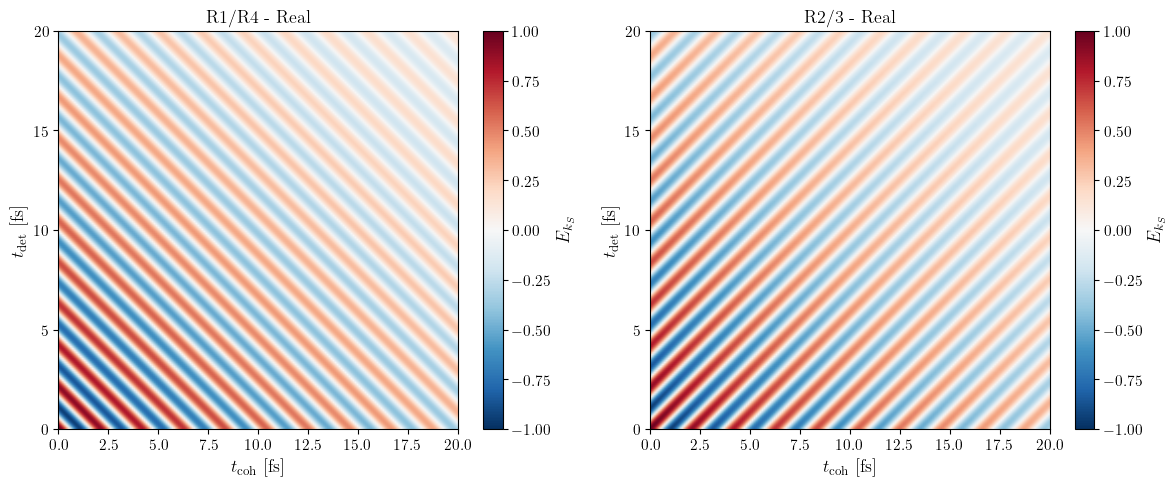

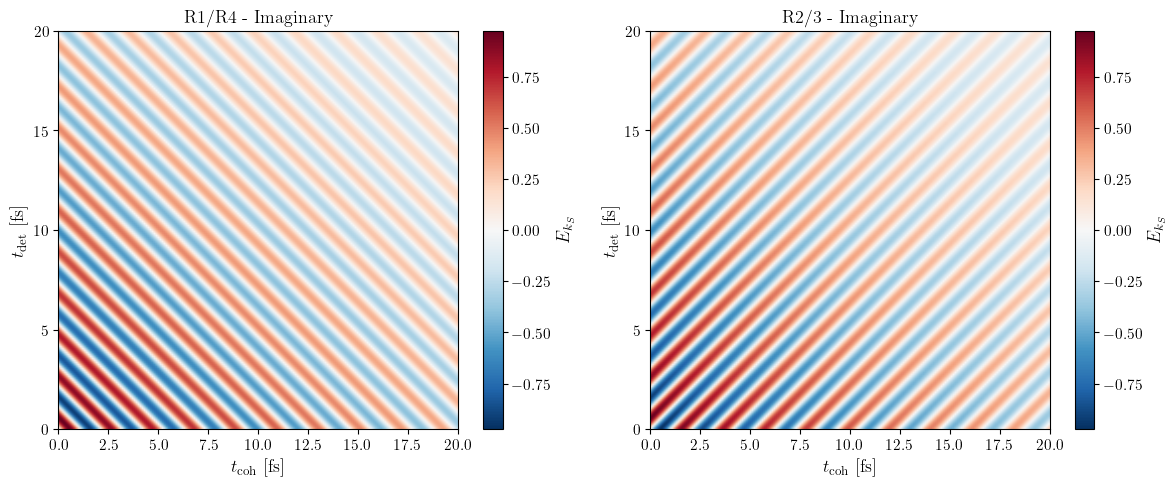

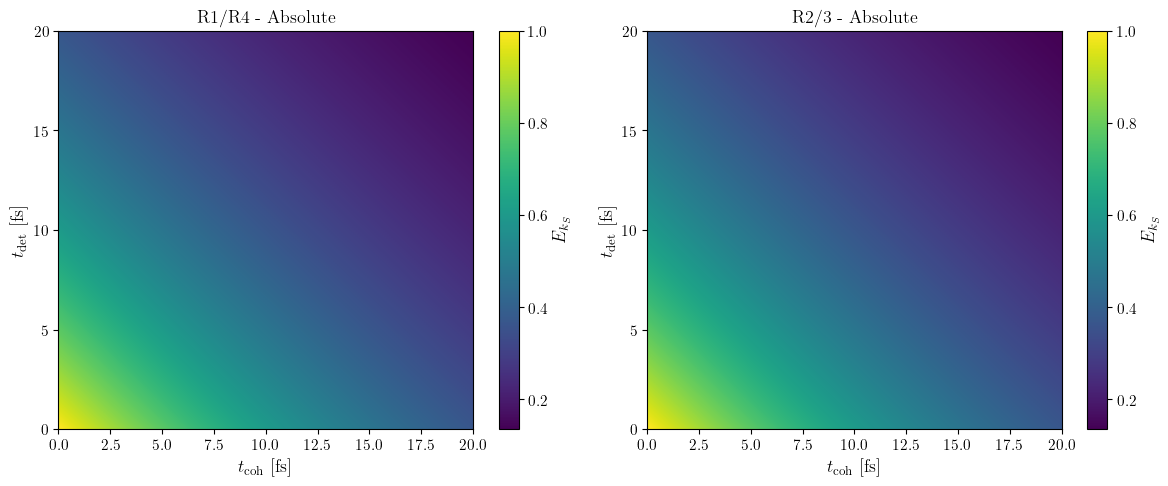

In [4]:
# Plot R1,R2 time domain - Real parts (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
responses_time = [R1_time, R2_time]
labels = ['R1/R4', 'R2/3']

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="real",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Real")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_real.png")
plt.show()

# Plot R1,R2 time domain - Imaginary parts (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="img",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Imaginary")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_img.png")
plt.show()

# Plot R1,R2 time domain - Absolute values (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="abs",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_abs.png")
plt.show()

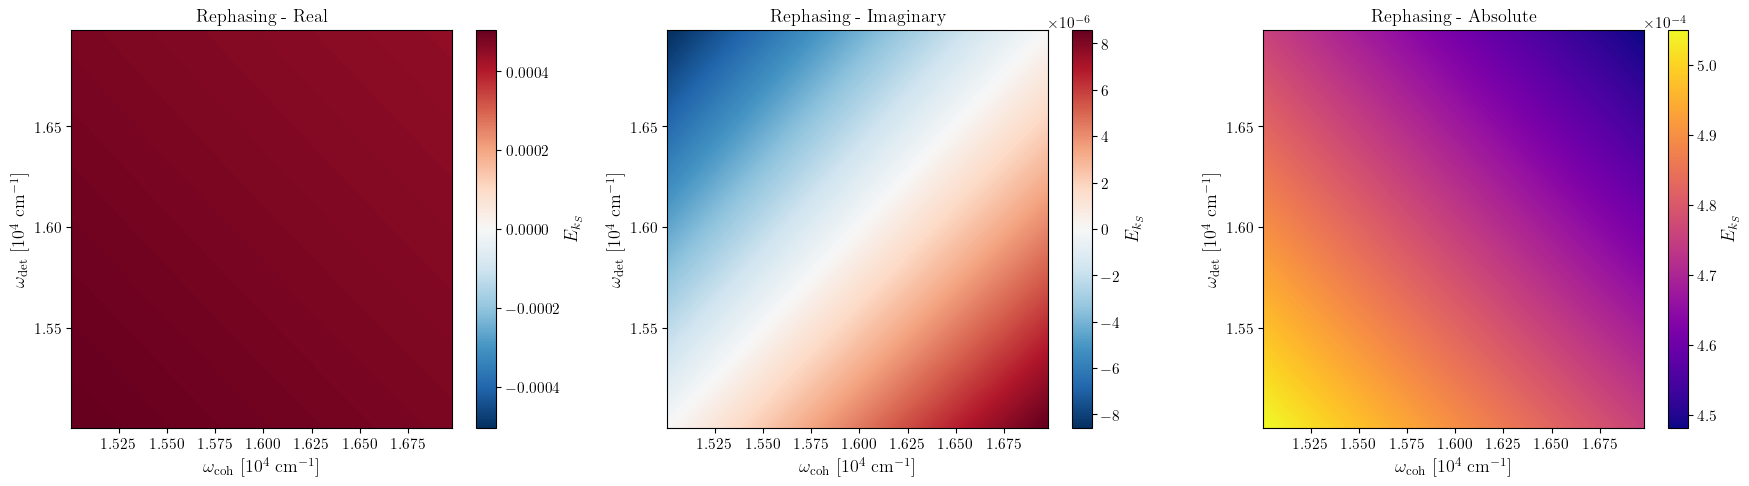

In [5]:
section = (1.5, 1.7)

# Plot rephasing spectra in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Rephasing - Real")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Rephasing - Imaginary")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "rephasing_spectra_combined.png")
plt.show()

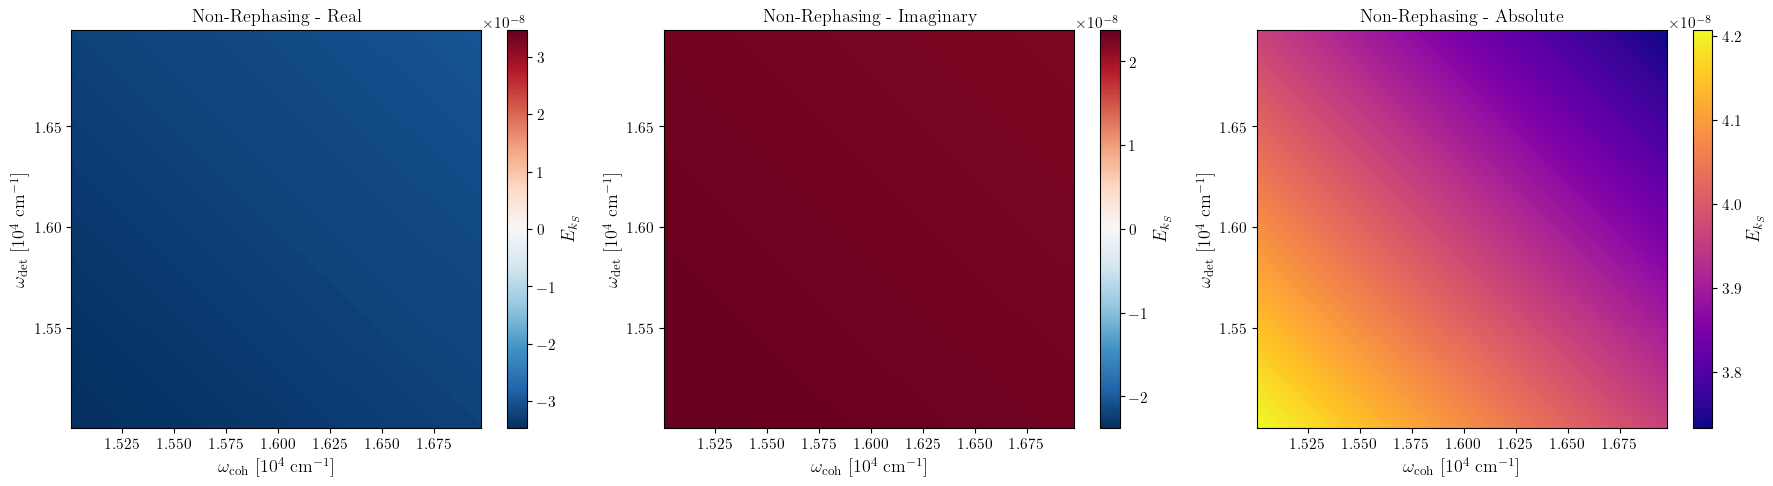

In [6]:
# Plot non-rephasing spectra in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Non-Rephasing - Real")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Non-Rephasing - Imaginary")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Non-Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "nonrephasing_spectra_combined.png")
plt.show()

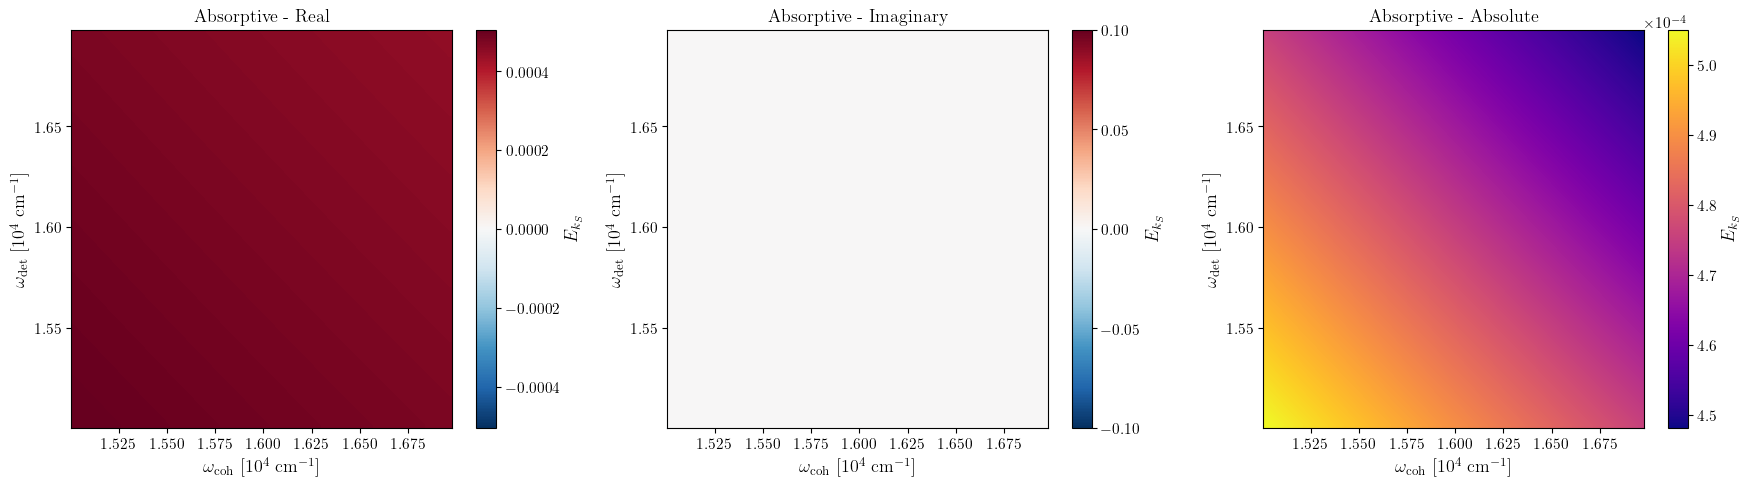

In [7]:
# Compute absorptive spectrum (complex sum)
absorptive = np.real(datas_nu[0] + datas_nu[1])

# Plot absorptive spectrum: real, imag, abs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Absorptive - Real")
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Absorptive - Imaginary")
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Absorptive - Absolute")
plt.tight_layout()
save_fig(fig, custom_dir / "absorptive_section.png")
plt.show()